In [1]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
import scipy
import numpy as np
import pickle
import gzip

In [2]:
def myinverse(x,ub,lb):
    res = np.zeros (len(ub))
    for i in range (len(ub)):
        res[i] = x[i] * (ub[i] - lb[i]) * 0.5 + (ub[i] + lb[i]) * 0.5

    return res

NumLayers=3

def elu(x):
    #Careful function ovewrites x
    ind=(x<0)
    x[ind]=np.exp(x[ind])-1
    return x

def eluPrime(y):
    # we make a deep copy of input x
    x=np.copy(y)
    ind=(x<0)
    x[ind]=np.exp(x[ind])
    x[~ind]=1
    return x

def NeuralNetwork_param(x,NNParameters):
    input1=x
    for i in range(NumLayers):
        input1=input1@NNParameters[i][0]+NNParameters[i][1]
        #Elu activation
        input1=elu(input1)
    #The output layer is linear
    i+=1
    
    return input1@NNParameters[i][0]+NNParameters[i][1]

def NeuralNetworkGradient_param(x,NNParameters,num_params):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(num_params)
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=input1@NNParameters[i][0]+NNParameters[i][1]
        grad=grad@NNParameters[i][0]
        #Elu activation
        grad*=eluPrime(input1)
        input1=elu(input1)
    grad= grad@NNParameters[i+1][0]
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad

In [3]:
def choice_calibrate(vol_surface):
    
    model_name=["rBergomi","Bergomi1Factor","Heston","VGSSD","NIGSSD"]
    num_params=[4,4,5,4,4]
    
    ub = [[0.16,4.,-0.100011,0.499998],
          [1.59997e-01,3.99999e+00,9.91655e+00,-7.11209e-06],
          [0.03999168,-0.1000106,0.99997076,0.19999979,9.99974068],
          [1.,1.,-0.2,0.6],
          [2.,10.,-0.1,0.6]]
    lb = [[0.0100133,0.300028,-0.949934,0.0250066],
          [1.00178e-02,5.00077e-01,6.01685e-05,-9.99552e-01],
          [1.00512775e-04,-9.49762936e-01,1.00139137e-02,1.32859527e-02,1.01770174e+00],
          [0.3,0.2,-2.,0.3],
          [0.1,0.2,-11.,0.3]]
    
    model_cat = Sequential()
    model_cat.add(Conv2D(32, kernel_size=(3, 3), activation="relu",input_shape=(8,11,1)))
    model_cat.add(MaxPooling2D(pool_size=(2, 2)))
    model_cat.add(Flatten())
    model_cat.add(Dense(32,activation = 'relu'))
    model_cat.add(Dense(32,activation = 'relu'))
    
    model_cat.add(Dense(5,activation = 'softmax'))
    
    model_cat.load_weights('ModelWeights/CategoriesNNWeights.h5')
    
    idx_vec = model_cat.predict(vol_surface.reshape(1,8,11,1))[0]
    idx = np.argmax(idx_vec)
    
    #print(idx_vec)
    
    print("Model selected: " + model_name[idx] + " with a precision of " + str(round(idx_vec[idx]*100,2))+"%")
    
    scale2 = pickle.load(open('Scales/'+model_name[idx]+'Scaler.pkl','rb'))
    
    f ="NNParams/"+model_name[idx]+"NNParams.npy"
    NNParameters = np.load(f,allow_pickle=True)
    
    def NeuralNetwork (x):
        return NeuralNetwork_param(x, NNParameters)
    def NeuralNetworkGradient (x):
        return NeuralNetworkGradient_param(x, NNParameters,num_params[idx])
    
    vol_transform = scale2.transform(vol_surface.reshape(1,88))
    
    def CostFuncLS(x):
        return (NeuralNetwork(x)-vol_transform.reshape(88))
    def JacobianLS(x):
        return NeuralNetworkGradient(x).T
    
    init = np.zeros(num_params[idx])
    I=scipy.optimize.least_squares(CostFuncLS,init,JacobianLS,gtol=1E-10)
    params = myinverse(I.x,ub[idx],lb[idx])
    
    return params

In [4]:
vola_1F = np.array([0.57082 , 0.514579, 0.464086, 0.419805, 0.380473, 0.344589,
       0.311389, 0.281852, 0.257049, 0.237843, 0.226023, 0.543843,
       0.492388, 0.447256, 0.406304, 0.368623, 0.333868, 0.301949,
       0.273193, 0.248624, 0.229844, 0.217796, 0.506208, 0.460093,
       0.419304, 0.382369, 0.348428, 0.317079, 0.288218, 0.262055,
       0.239336, 0.221267, 0.208746, 0.479372, 0.436928, 0.399483,
       0.36565 , 0.334606, 0.305915, 0.279422, 0.255275, 0.234029,
       0.216599, 0.203765, 0.457889, 0.418489, 0.383774, 0.352503,
       0.323857, 0.297358, 0.272835, 0.250406, 0.230493, 0.213793,
       0.200949, 0.439638, 0.403046, 0.370797, 0.341742, 0.315159,
       0.290621, 0.267938, 0.247143, 0.228515, 0.212569, 0.199844,
       0.425869, 0.391526, 0.361265, 0.334034, 0.309157, 0.286223,
       0.265022, 0.245537, 0.227958, 0.212669, 0.200107, 0.418342,
       0.385302, 0.35621 , 0.330043, 0.306144, 0.284108, 0.263734,
       0.244992, 0.228022, 0.213127, 0.200685])
vola_Heston = np.array([0.30589313, 0.25938753, 0.26559668, 0.27087143, 0.27544738,
       0.27947933, 0.28307693, 0.28632039, 0.28927003, 0.29197227,
       0.29446356, 0.33525328, 0.33916105, 0.34243849, 0.34525766,
       0.34772891, 0.34992724, 0.35190585, 0.35370386, 0.35535087,
       0.35686979, 0.35827871, 0.37284728, 0.37518921, 0.37716199,
       0.37886544, 0.38036376, 0.38170068, 0.38290732, 0.3840066 ,
       0.3850159 , 0.38594871, 0.3868157 , 0.38674206, 0.38840322,
       0.38980446, 0.39101584, 0.39208247, 0.39303511, 0.39389566,
       0.39468027, 0.39540117, 0.3960679 , 0.39668797, 0.3938646 ,
       0.39514272, 0.39622152, 0.39715464, 0.39797665, 0.39871112,
       0.39937484, 0.39998019, 0.40053658, 0.40105131, 0.40153014,
       0.39811111, 0.3991496 , 0.40002644, 0.40078509, 0.40145358,
       0.40205102, 0.40259102, 0.40308363, 0.40353648, 0.40395548,
       0.40434533, 0.40097146, 0.40184407, 0.402581  , 0.40321874,
       0.40378077, 0.40428314, 0.40473728, 0.40515162, 0.40553255,
       0.40588504, 0.40621305, 0.40239454, 0.40318334, 0.40384957,
       0.40442617, 0.40493437, 0.40538865, 0.40579935, 0.40617407,
       0.40651861, 0.40683744, 0.40713414])


In [163]:
choice_calibrate_2(vola_1F-0.1)

Model selected: Bergomi1Factor with a precision of 97.5%


array([ 0.05905479,  1.77297096,  0.53461417, -0.89311439])

In [98]:
def Sq_Err(arr1,arr2):
    return np.sum((arr1-arr2)**2)

def calibrate_error(NNParameters,num_params,vola):
    
    def NeuralNetwork (x):
        return NeuralNetwork_param(x, NNParameters)
    def NeuralNetworkGradient (x):
        return NeuralNetworkGradient_param(x, NNParameters,num_params)
    
    def CostFuncLS(x):
        return (NeuralNetwork(x)-vola.reshape(88))
    def JacobianLS(x):
        return NeuralNetworkGradient(x).T
    
    init = np.zeros(num_params)
    I=scipy.optimize.least_squares(CostFuncLS,init,JacobianLS,gtol=1E-15)
    
    vola_cal = NeuralNetwork(I.x)
    
    return Sq_Err(vola,vola_cal)

In [129]:
def model_check(vola,stamp=True,ret=False):
    model_name=["rBergomi","Bergomi1Factor","Heston","VGSSD","NIGSSD"]
    num_params=[4,4,5,4,4]
    
    best_idx = 0
    best_guess = np.infty
    
    for i in range(len(model_name)):
        scale = pickle.load(open('Scales/'+model_name[i]+'Scaler.pkl','rb'))

        f ="NNParams/"+model_name[i]+"NNParams.npy"
        NNParameters = np.load(f,allow_pickle=True)
        
        err = calibrate_error(NNParameters,num_params[i],scale.transform(vola.reshape(1,88)))
        
        if err < best_guess:
            best_idx = i
            best_guess = err
        if stamp:
            print ("Error "+model_name[i]+": "+str(err))
    if ret:
        return best_idx
    return

In [164]:
model_check(vola_1F-0.1)

Error rBergomi: 0.8467110412294813
Error Bergomi1Factor: 1.089158293514955
Error Heston: 55.78217783341947
Error VGSSD: 0.5784749808919531
Error NIGSSD: 0.11236652006610202


In [110]:
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

model_name=["rBergomi","Bergomi1Factor","Heston","VGSSD","NIGSSD"]
num_params=[4,4,5,4,4]

num_models = len(model_name)

f = gzip.GzipFile('Dataset/' + model_name[0] + 'TrainSet.txt.gz', "r")
dat = np.load(f)
f.close()

yy = []
xx = dat[1:2, num_params[0]:]

for i in range(len(model_name)):

    f = gzip.GzipFile('Dataset/' + model_name[i] + 'TrainSet.txt.gz', "r")
    dat = np.load(f)
    f.close()
    print(dat.shape)
    xx = np.concatenate((xx,dat[:, num_params[i]:]))
    yy+=[i]*len(dat)

xx = xx[1:,:]
yy=np.array(yy)

(40000, 92)
(40000, 92)
(12000, 93)
(103537, 92)
(84196, 92)


In [186]:
eps = 1e-5
model_check(vola_Heston+eps,stamp=True,ret=True)

Error rBergomi: 19.276192161762204
Error Bergomi1Factor: 21.698700418075624
Error Heston: 0.0053464933362126
Error VGSSD: 0.2606568376553584
Error NIGSSD: 0.029713125046681995


2

In [173]:
choice_calibrate(vola_Heston+eps)

Model selected: Heston with a precision of 99.94%


array([ 0.02681946, -0.35487117,  0.20079284,  0.16529544,  8.56122735])

In [178]:
yy_best_np = np.array(yy_best)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder

from keras.utils import to_categorical

yy_0 = to_categorical(yy_best_np,num_classes = num_models)
xx_shaped = xx.reshape(len(xx),len(maturities),len(strikes),1)

X_train, X_test, y_train, y_test = train_test_split(xx_shaped, yy_0, test_size=0.3, random_state=42)
y_test_num = np.argmax(y_test,axis=1)

In [150]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation="relu",input_shape=(len(maturities),len(strikes),1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(32,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))

model.add(Dense(num_models,activation = 'softmax'))

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['acc'])

#earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=150)

model_history = model.fit(X_train,y_train,batch_size=64,validation_split = 0.2,epochs = 20)

model.save_weights('ModelWeights/BestCategoriesNNWeights.h5')

Epoch 1/20
2448/2448 [==============================] - 9s 3ms/step - loss: 0.6370 - acc: 0.7016 - val_loss: 0.5359 - val_acc: 0.7562
Epoch 2/20
2448/2448 [==============================] - 9s 4ms/step - loss: 0.5329 - acc: 0.7540 - val_loss: 0.5088 - val_acc: 0.7620
Epoch 3/20
2448/2448 [==============================] - 9s 4ms/step - loss: 0.5030 - acc: 0.7661 - val_loss: 0.4903 - val_acc: 0.7665
Epoch 4/20
2448/2448 [==============================] - 9s 4ms/step - loss: 0.4745 - acc: 0.7813 - val_loss: 0.4496 - val_acc: 0.7955
Epoch 5/20
2448/2448 [==============================] - 10s 4ms/step - loss: 0.4439 - acc: 0.7999 - val_loss: 0.4218 - val_acc: 0.8011
Epoch 6/20
2448/2448 [==============================] - 10s 4ms/step - loss: 0.4130 - acc: 0.8163 - val_loss: 0.4055 - val_acc: 0.8181
Epoch 7/20
2448/2448 [==============================] - 10s 4ms/step - loss: 0.3852 - acc: 0.8297 - val_loss: 0.3601 - val_acc: 0.8379
Epoch 8/20
2448/2448 [==============================] - 9s 

In [151]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

accr = model.evaluate(X_test, y_test)

2623/2623 [==============================] - 3s 1ms/step - loss: 0.1573 - acc: 0.9326


In [152]:
y_pred = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<AxesSubplot:>

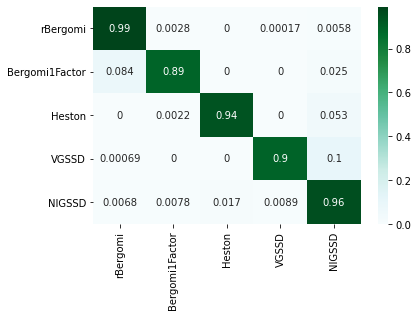

In [153]:
cm = confusion_matrix(y_test_num,y_pred,normalize='true')
df_cm = pd.DataFrame(cm,model_name,model_name)
sns.heatmap(df_cm,annot=True,cmap=plt.cm.BuGn)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 5)

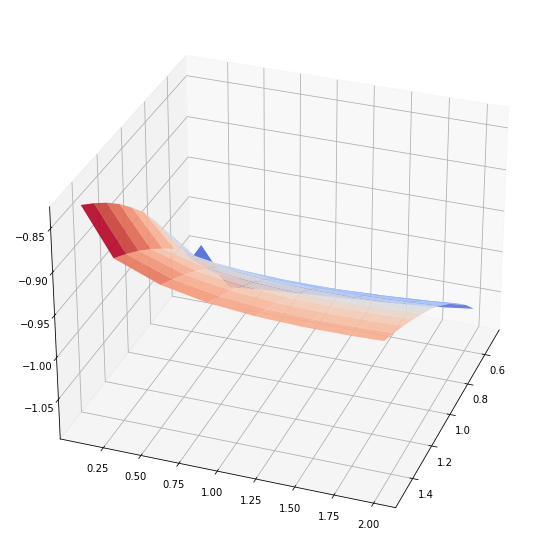

In [93]:
import matplotlib.pyplot as plt
from matplotlib import cm

strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5])
maturities = np.array([0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(10,10))

X_maturities, Y_strikes = np.meshgrid(strikes,maturities)
ax.view_init(30,20)
surf = ax.plot_surface(X_maturities, Y_strikes,scale2.transform(vola_Heston.reshape(1,88)).reshape(len(maturities),len(strikes)),linewidth=0,alpha = 0.9,cmap=cm.coolwarm, antialiased=True)
ax.scatter(X_maturities, Y_strikes,NeuralNetwork(I.x).reshape(len(maturities),len(strikes)),color="k",alpha=1)#,linewidth=10,alpha = 1,cmap=cm.winter, antialiased=True)


In [154]:
def choice_calibrate_2(vol_surface):
    
    model_name=["rBergomi","Bergomi1Factor","Heston","VGSSD","NIGSSD"]
    num_params=[4,4,5,4,4]
    
    ub = [[0.16,4.,-0.100011,0.499998],
          [1.59997e-01,3.99999e+00,9.91655e+00,-7.11209e-06],
          [0.03999168,-0.1000106,0.99997076,0.19999979,9.99974068],
          [1.,1.,-0.2,0.6],
          [2.,10.,-0.1,0.6]]
    lb = [[0.0100133,0.300028,-0.949934,0.0250066],
          [1.00178e-02,5.00077e-01,6.01685e-05,-9.99552e-01],
          [1.00512775e-04,-9.49762936e-01,1.00139137e-02,1.32859527e-02,1.01770174e+00],
          [0.3,0.2,-2.,0.3],
          [0.1,0.2,-11.,0.3]]
    
    model_cat = Sequential()
    model_cat.add(Conv2D(32, kernel_size=(3, 3), activation="relu",input_shape=(8,11,1)))
    model_cat.add(MaxPooling2D(pool_size=(2, 2)))
    model_cat.add(Flatten())
    model_cat.add(Dense(32,activation = 'relu'))
    model_cat.add(Dense(32,activation = 'relu'))
    
    model_cat.add(Dense(5,activation = 'softmax'))
    
    model_cat.load_weights('ModelWeights/BestCategoriesNNWeights.h5')
    
    idx_vec = model_cat.predict(vol_surface.reshape(1,8,11,1))[0]
    idx = np.argmax(idx_vec)
    
    #print(idx_vec)
    
    print("Model selected: " + model_name[idx] + " with a precision of " + str(round(idx_vec[idx]*100,2))+"%")
    
    scale2 = pickle.load(open('Scales/'+model_name[idx]+'Scaler.pkl','rb'))
    
    f ="NNParams/"+model_name[idx]+"NNParams.npy"
    NNParameters = np.load(f,allow_pickle=True)
    
    def NeuralNetwork (x):
        return NeuralNetwork_param(x, NNParameters)
    def NeuralNetworkGradient (x):
        return NeuralNetworkGradient_param(x, NNParameters,num_params[idx])
    
    vol_transform = scale2.transform(vol_surface.reshape(1,88))
    
    def CostFuncLS(x):
        return (NeuralNetwork(x)-vol_transform.reshape(88))
    def JacobianLS(x):
        return NeuralNetworkGradient(x).T
    
    init = np.zeros(num_params[idx])
    I=scipy.optimize.least_squares(CostFuncLS,init,JacobianLS,gtol=1E-10)
    params = myinverse(I.x,ub[idx],lb[idx])
    
    return params

In [47]:
i = np.argmax(idx)

In [60]:
idx

array([2.4704263e-04, 9.9974114e-01, 0.0000000e+00, 1.1847736e-05,
       2.1017997e-31], dtype=float32)

In [50]:
print("ciao: "+"%.2f" %idx[i])

ciao: 0.99974
